### Installs, imports and settings

In [1]:
# Datasets:
# DATASET = 'n-f-n'
DATASET = 's-f-o'
# DATASET = 's-f-c'
# DATASET = 's-r-5o'
# DATASET = 's-r-5c'
# DATASET = 's-r-10c'

# Models:
MODEL = 'wavlm-basic'
# MODEL = 'wavlm-extras'
# MODEL = 'wav2vec2'
# MODEL = 'standalone'

# Learning parameters:
FREEZING = False
BATCH_SIZE = 8
LEARNING_RATE = 1e-4
AUDIO_LENGTH_SEC = 5

In [2]:
DATASET_NAME = "reralle/" + DATASET
FREEZE_STRING = 'freezing' if FREEZING else 'unfrozen'
OUTPUT_MODEL = MODEL + "_" + DATASET + "_" + str(BATCH_SIZE) + "batch_" + str(AUDIO_LENGTH_SEC) + "sec_" + str(LEARNING_RATE) + "lr_" + FREEZE_STRING
OUTPUT_MODEL = "reralle/" + OUTPUT_MODEL

In [3]:
%%capture
!pip install transformers datasets evaluate

In [4]:
from datasets import load_dataset, load_metric, Audio
from transformers import AutoConfig, AutoFeatureExtractor
import torch
import evaluate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Audio as IPythonAudio
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report
from datetime import datetime
import seaborn as sns

In [5]:
from transformers import WavLMForSequenceClassification
BASE_MODEL = "microsoft/wavlm-large"

## Loading data

In [7]:
df = pd.read_csv(r"/content/proficiency_groups.csv")

In [8]:
df.head()

,Unnamed: 0,url-id,label,proficiency,prof-group
0,1,301,russian,89.521083,5
1,2,299,russian,17.869220,1
2,3,288,portuguese,41.011974,2
3,4,286,portuguese,45.486759,2
4,5,183,french,65.944756,4


In [9]:
dataset = load_dataset(DATASET_NAME)
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label
num_labels = len(id2label)
dataset = dataset.cast_column("audio", Audio(sampling_rate=16_000))

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/4200 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/60 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/60 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/reralle___parquet/reralle--s-f-o-1d754b55da0d4e3f/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [10]:
feature_extractor = AutoFeatureExtractor.from_pretrained(BASE_MODEL)

def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays, 
        sampling_rate=feature_extractor.sampling_rate, 
        max_length=AUDIO_LENGTH_SEC * 16000, 
        truncation=True, 
    )
    return inputs

encoded_dataset = dataset['test'].map(preprocess_function, batched=True)
encoded_dataset

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

Dataset({
    features: ['audio', 'label', 'input_values', 'attention_mask'],
    num_rows: 60
})

In [11]:
encoded_dataset2 = dataset['validation'].map(preprocess_function, batched=True)
encoded_dataset2

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

Dataset({
    features: ['audio', 'label', 'input_values', 'attention_mask'],
    num_rows: 60
})

In [12]:
model = WavLMForSequenceClassification.from_pretrained(OUTPUT_MODEL, num_labels=num_labels, label2id=label2id, id2label=id2label)

model.eval() 

WavLMForSequenceClassification(
  (wavlm): WavLMModel(
    (feature_extractor): WavLMFeatureEncoder(
      (conv_layers): ModuleList(
        (0): WavLMLayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1-4): 4 x WavLMLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (5-6): 2 x WavLMLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): WavLMFeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, element

In [13]:
df['success'] = 0

In [16]:
# This is where we see whether the fine-tuned model accurately classified the speakers

for i in dataset['test']:  # run also with 'test'
  url_id = int(i['audio']['path'][:-6])
  label = i['label']

  filtered_df = df[df['url-id']==url_id]
  if len(filtered_df) == 0:
    break

  index = df[df['url-id']==url_id].index[0]
  prof_score = df.at[index, 'proficiency']
  str_label = df.at[index, 'label']

  model_input = feature_extractor(i['audio']['array'], sampling_rate=feature_extractor.sampling_rate, max_length=AUDIO_LENGTH_SEC * 16000, truncation=True)
  input_values = torch.tensor(model_input['input_values']).to(model.device)
  attention_mask = torch.tensor(model_input['attention_mask']).to(model.device)

  with torch.no_grad():
    logits = model(input_values, attention_mask=attention_mask).logits

  logit = logits[0][label].item()

  pred_id = torch.argmax(logits[0], dim=-1).cpu().numpy()
  if pred_id.item() == label:
    df.at[index, 'success'] = 1

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [17]:
df.success.value_counts()

1    78
0    18
Name: success, dtype: int64

In [18]:
df

,Unnamed: 0,url-id,label,proficiency,prof-group,success
0,1,301,russian,89.521083,5,0
1,2,299,russian,17.869220,1,1
2,3,288,portuguese,41.011974,2,1
3,4,286,portuguese,45.486759,2,1
4,5,183,french,65.944756,4,1
...,...,...,...,...,...,...
91,111,633,french,36.445224,1,1
92,112,609,russian,60.550903,3,1
93,113,608,korean,11.042369,1,1
94,117,483,korean,35.910425,1,1


## First plot: probability of correct classification per language proficiency group

In [29]:
# Change the 5 bins into two instead
df['prof-group'] = pd.qcut(df['proficiency'], 3, labels=['Low', 'Middle', 'High'])

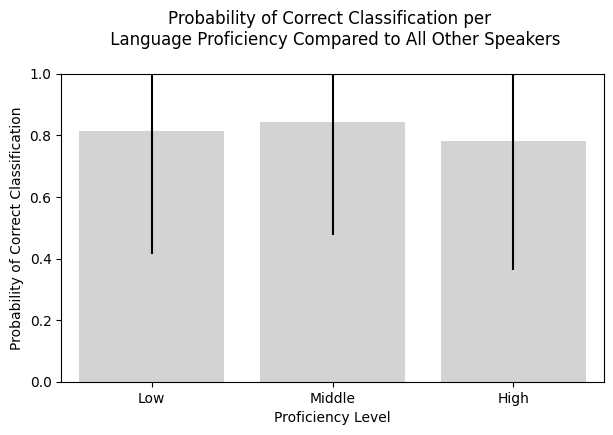

In [36]:
# calculate mean and standard deviation of success rate for each proficiency group
grouped = df.groupby('prof-group')['success'].agg(['mean', 'std'])

# reset index so 'prof-group' becomes a column
grouped = grouped.reset_index()

# create bar plot with seaborn
plt.figure(figsize=(7, 4))  # smaller size
sns.barplot(x='prof-group', y='mean', data=grouped, yerr=grouped['std'], capsize=.2, color='lightgrey')

plt.xlabel('Proficiency Level')
plt.ylabel('Probability of Correct Classification')
plt.title('Probability of Correct Classification per \n Language Proficiency Compared to All Other Speakers\n')
plt.ylim(0, 1)

plt.show()



# Second plot: Probability of correct classification per proficiency compared to those with the same native tounge

In [1]:
# I have 12 speakers per accent
# Perhaps 3 grops are resonable? Then there are four per group
#

In [22]:
df[df['label']=='dutch']

,Unnamed: 0,url-id,label,proficiency,prof-group,success,third
6,9,58,dutch,38.800478,2,1,Middle
11,14,2989,dutch,33.958183,1,0,Low
37,43,2115,dutch,60.101165,3,1,High
54,61,1740,dutch,29.025851,1,1,Low
58,67,1517,dutch,60.930788,3,1,High
59,68,1484,dutch,37.332133,2,1,Middle
62,71,1466,dutch,35.390573,1,0,Low
63,72,1464,dutch,24.794415,1,1,Low
72,86,1300,dutch,42.354942,2,0,Middle
75,89,1275,dutch,37.080502,1,0,Middle


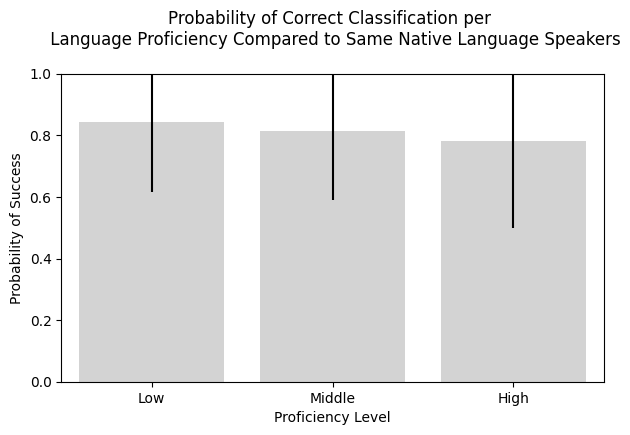

In [37]:
# First, calculate the third percentiles for each language
df['third'] = df.groupby('label')['proficiency'].transform(
    lambda x: pd.qcut(x, 3, labels=['Low', 'Middle', 'High'])
)

# Then, calculate the success rate for each language and proficiency group
success_rate = df.groupby(['label', 'third'])['success'].mean().reset_index()

# Now, calculate the mean and standard deviation of success rate for each proficiency group across all languages
grouped = success_rate.groupby('third')['success'].agg(['mean', 'std']).reset_index()

# Create bar plot with seaborn
plt.figure(figsize=(7, 4))  # smaller size
sns.barplot(x='third', y='mean', data=grouped, yerr=grouped['std'], capsize=.2, color='lightgrey')

plt.xlabel('Proficiency Level')
plt.ylabel('Probability of Success')
plt.title('Probability of Correct Classification per \n Language Proficiency Compared to Same Native Language Speakers\n')
plt.ylim(0, 1)
plt.show()
